## Tabular Data with fastai

In [1]:
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

### Blue Book for Bulldozers Kaggle Competition

In [2]:
# pick a destination path
path = URLs.path('bluebook')
path

Path('/Users/chhilty/.fastai/archive/bluebook')

In [3]:
# set base path
Path.BASE_PATH = path

In [7]:
# download the dataset
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

  0%|          | 0.00/48.4M [00:00<?, ?B/s]

100%|██████████| 48.4M/48.4M [00:11<00:00, 4.41MB/s]


(#7) [Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('median_benchmark.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('TrainAndValid.csv')]

### Inspect the Data

In [34]:
# read in the data
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [35]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [36]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


#### Handle Ordinal Columns

In [37]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [38]:
# set correct ordinal order
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [39]:
df['ProductSize'].dtypes

dtype('O')

In [40]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [41]:
df['ProductSize'].dtypes

CategoricalDtype(categories=['Large', 'Large / Medium', 'Medium', 'Small', 'Mini',
                  'Compact'],
                 ordered=True)

#### Target Variable

In [42]:
# the dependent variable we need to predict is the log of the sale price
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

#### Date Handling

In [43]:
# convert date to meaningful variable
cols_before = df.columns

df = add_datepart(df, 'saledate')

In [51]:
# inspect our newly added columns
set(df.columns) - set(cols_before)

{'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleElapsed',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleMonth',
 'saleWeek',
 'saleYear'}

In [52]:
# make same for test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [54]:
# lets inspect our new columns in another way
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

#### Using TabularPandas and TabularProc 

In [62]:
# split our time series data
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [64]:
# define continuous and categorical columns
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
cont[:3], cat[:3]

(['SalesID', 'MachineID', 'ModelID'], ['saleWeek', 'UsageBand', 'fiModelDesc'])

Hmm...I am not really happy about MachineID beeing a continous variable though..

In [66]:
# define processings for our data
procs = [Categorify, FillMissing]

In [67]:
# create TabularPandas object
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train),len(to.valid)

(404710, 7988)

In [68]:
# show some data
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [71]:
# show categorical and continous
to.cat_names, to.cont_names

((#54) ['saleWeek','UsageBand','fiModelDesc','fiBaseModel','fiSecondaryDesc','fiModelSeries','fiModelDescriptor','ProductSize','fiProductClassDesc','state'...],
 (#12) ['SalesID','MachineID','ModelID','datasource','auctioneerID','YearMade','MachineHoursCurrentMeter','saleYear','saleMonth','saleDay'...])

In [72]:
# show power of TabularPandas
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], 
                    [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


The group is still present in the TabularPandas but the underlying items are now numeric.

In [77]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [78]:
# save our data for later access
(path/'to.pkl').save(to)

### Decision Tree

In [80]:
# reload model for demonstration
to = None
to = (path/'to.pkl').load()
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [81]:
# split dependent and independent vars
xs, y = to.train.xs, to.train.y
xs_valid, y_valid = to.valid.xs, to.valid.y

In [82]:
# now we can create our decision tree (keep it simple with 4 leaf nodes)
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [88]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """Draws a representation of a random forest in IPython."""
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

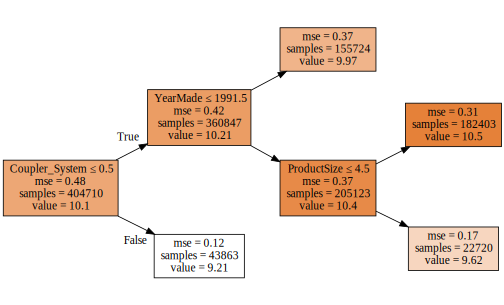

In [89]:
from sklearn.tree import export_graphviz

draw_tree(m, xs, size=7, precision=2)

In [ ]:
a